In [ ]:
! pip install gensim
! pip install beautifulsoup4
! pip install wordcloud
! pip install tqdm

Подгружаем данные:

In [1]:
import pandas as pd

train = pd.read_csv("labeledTrainData.tsv", header=0,
                    delimiter="\t", quoting=3)

In [2]:
train['review'].iloc[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

Видно, что в данных присутствуют элементы html.

- избавимся от элементов html  с помощью модуля BeautifulSoup: 
    http://nullege.com/codes/search/bs4.BeautifulSoup.getText
- оставим только буквы
- приведем все к нижнему регистру
- уберем стоп слова

In [3]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

In [4]:
def review_to_words(raw_review):
    # your code is hear
    # 1. bs
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. regular expression
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    # 3. to lower
    words = letters_only.lower().split()
    # 4. drop stopwords
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    
    return words 

In [5]:
review_to_words(train['review'].iloc[0])

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary',
 'watched',
 'wiz',
 'watched',
 'moonwalker',
 'maybe',
 'want',
 'get',
 'certain',
 'insight',
 'guy',
 'thought',
 'really',
 'cool',
 'eighties',
 'maybe',
 'make',
 'mind',
 'whether',
 'guilty',
 'innocent',
 'moonwalker',
 'part',
 'biography',
 'part',
 'feature',
 'film',
 'remember',
 'going',
 'see',
 'cinema',
 'originally',
 'released',
 'subtle',
 'messages',
 'mj',
 'feeling',
 'towards',
 'press',
 'also',
 'obvious',
 'message',
 'drugs',
 'bad',
 'kay',
 'visually',
 'impressive',
 'course',
 'michael',
 'jackson',
 'unless',
 'remotely',
 'like',
 'mj',
 'anyway',
 'going',
 'hate',
 'find',
 'boring',
 'may',
 'call',
 'mj',
 'egotist',
 'consenting',
 'making',
 'movie',
 'mj',
 'fans',
 'would',
 'say',
 'made',
 'fans',
 'true',
 'really',
 'nice',
 'actual',
 'feature',
 'film',
 'bit',
 'finally',
 'starts',
 'minutes',
 'excluding',
 'smooth',
 'crim

Примените реализованную функцию к каждому предожению train

In [6]:
from tqdm import tqdm

#num_reviews = train["review"].size
num_reviews = 1000

clean_train_reviews = []

for i in tqdm(range(num_reviews)):
    clean_train_reviews.append(review_to_words(train["review"][i]))

100%|█████████████████████████████████████| 1000/1000 [00:03<00:00, 296.78it/s]


Обучите word2vec

In [7]:
num_features = 100    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

from gensim.models import word2vec

model = word2vec.Word2Vec(clean_train_reviews, workers=num_workers, 
                          size=num_features, min_count = min_word_count, 
                          window = context, sample = downsampling)

model.init_sims(replace=True)

# модель можно сохранить
# model_name = ''
# model.save(model_name)

C:\Users\sanek\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Теперь можно воспользjваться функциями поиска похожих / непохожих слов на данное
- model.wv.most_similar
- model.wv.doesnt_match
- etc

In [8]:
# здесь можно посмотреть все слова, к которым мы имеем вектора
# model.wv.vocab

In [9]:
model.wv.most_similar('mother')

[('star', 0.9998201727867126),
 ('children', 0.9998053908348083),
 ('job', 0.9998041987419128),
 ('stars', 0.9998030662536621),
 ('quite', 0.9997974634170532),
 ('child', 0.9997932314872742),
 ('head', 0.9997889995574951),
 ('set', 0.9997837543487549),
 ('goes', 0.9997831583023071),
 ('taking', 0.9997824430465698)]

In [10]:
model.wv.doesnt_match("man woman child".split())

'man'

In [11]:
model.wv.doesnt_match(["sun", "moon", "planet", "earth"])

'earth'

In [12]:
model.wv.most_similar("girl")

[('child', 0.9998079538345337),
 ('tries', 0.9997885227203369),
 ('friends', 0.9997885227203369),
 ('played', 0.9997878074645996),
 ('comic', 0.9997854232788086),
 ('especially', 0.9997826814651489),
 ('wife', 0.9997814893722534),
 ('taking', 0.9997786283493042),
 ('works', 0.9997777938842773),
 ('dark', 0.9997742176055908)]

In [13]:
model.wv.most_similar("horror")

[('blood', 0.9996651411056519),
 ('moments', 0.9996578693389893),
 ('beautiful', 0.9996554851531982),
 ('fans', 0.9996466040611267),
 ('black', 0.9996375441551208),
 ('quite', 0.9996352791786194),
 ('mean', 0.9996288418769836),
 ('genre', 0.9996269941329956),
 ('true', 0.9996254444122314),
 ('sure', 0.999624490737915)]

Теперь выделите top 100 самых частотных слов и получите для них только что обученные вектора

In [14]:
from nltk import FreqDist

fd = FreqDist()
for text in clean_train_reviews:
    for word in text:
        fd[word]+=1

In [15]:
top_words = [el[0] for el in fd.most_common(100)]
top_words_vec = model.wv[top_words]

Визуализируем вектора. Для этого воспользуемся методом снижения размерности t-sne

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [17]:
print(top_words_vec.shape)
print(top_words_tsne.shape)

(100, 100)
(100, 2)


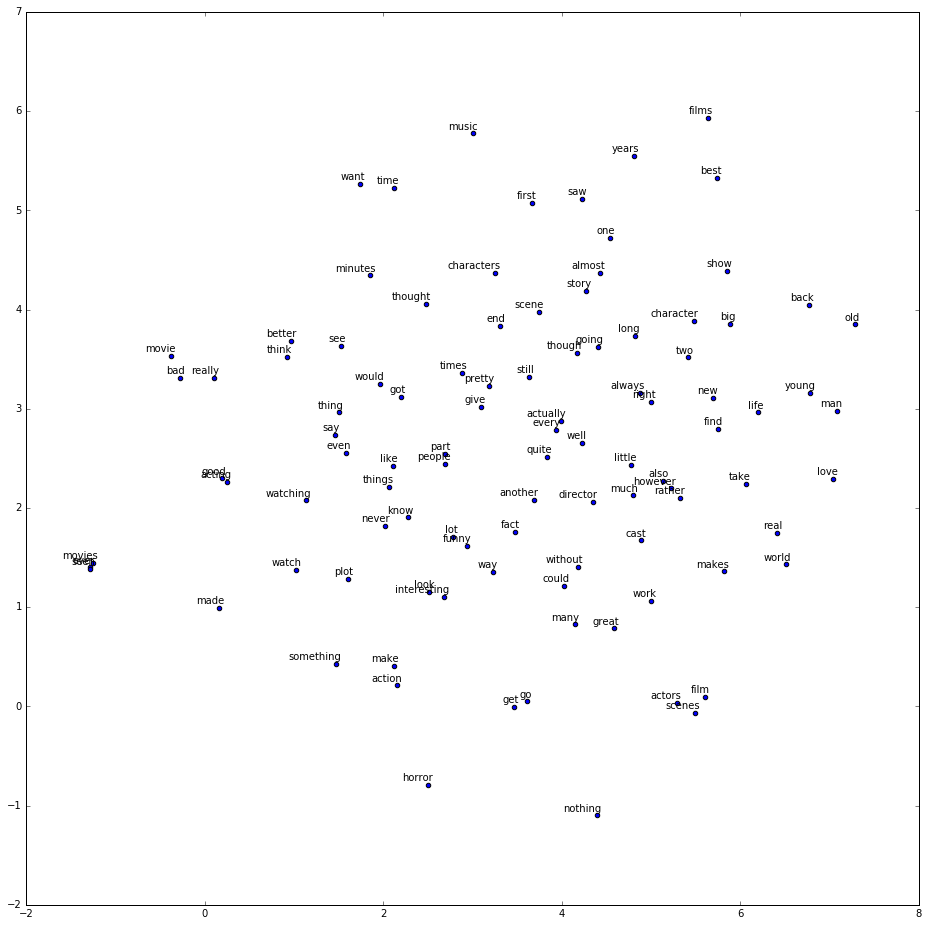

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

x = []
y = []
for value in top_words_tsne:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(100):
    plt.scatter(x[i],y[i])
    plt.annotate(top_words[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

Теперь нарисуйте облако слов

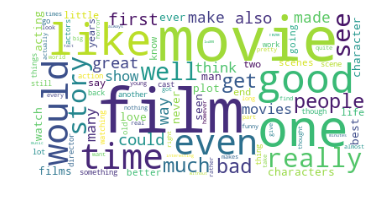

In [19]:
from wordcloud import *
word_freq = [i for i in fd.most_common(100)]
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()